# Evaluate Models

## Imports

In [1]:
import os.path

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader

from torchvision import transforms

import yaml
import json

from model import RandomlyConnectedModel

from evaluation.hamlyn import evaluate_ssim
from evaluation.scared import evaluate_keyframes
from evaluation.utils import prepare_state_dict
from evaluation import sparsification
from evaluation import transforms as t

from loaders.hamlyn import HamlynDataset
from loaders.scared import SCAREDKeyframesLoader

## Configuration

In [2]:
model_name = 'uncertainty-log.pt'
model_config = 'uncertainty-config.yml'

datasets_path = '../datasets/'
hamlyn_path = os.path.join(datasets_path, 'da-vinci')
scared_path = os.path.join(datasets_path, 'scared')

batch_size = 8
min_depth = 4.676 # mm
max_depth = 180.554 # mm

save_to = 'results'

In [3]:
device = torch.device('cuda') \
    if torch.cuda.is_available() \
    else torch.device('cpu')

print(f'Using CUDA? {"cuda" in repr(device)}')

with open(model_config) as f:
    config = yaml.load(f, Loader=yaml.Loader)

model = RandomlyConnectedModel(**config).to(device)

model_stem = os.path.splitext(model_name)[0]
model_save_to = os.path.join('results', model_stem)

hamlyn_transform = transforms.Compose([
    t.ResizeImage((256, 512)),
    t.ToTensor()
])

scared_transform = transforms.Compose([
    t.ResizeImage((1024, 1280)),
    t.ToTensor()
])

results_dict = {}

Using CUDA? True


## Hamlyn SSIM/Sparsification

### Setup

In [4]:
hamlyn_model_path = os.path.join('models', 'hamlyn', model_name)
hamlyn_save_to = os.path.join(model_save_to, 'hamlyn')

state_dict = torch.load(hamlyn_model_path, map_location=device)
state_dict = prepare_state_dict(state_dict)

model.load_state_dict(state_dict)

hamlyn_dataset = HamlynDataset(hamlyn_path, 'test', hamlyn_transform)
hamlyn_dataloader = DataLoader(hamlyn_dataset, batch_size, num_workers=8,
                               shuffle=True, drop_last=True)

### Run Hamlyn Evaluation

In [6]:
ssims, spars = evaluate_ssim(model, hamlyn_dataloader, hamlyn_save_to, kernel=1, device=device)

SSIM Evaluation:   0%|          | 0/898 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
SSIM Evaluation: 100%|██████████| 898/898 [10:18<00:00,  1.45batch/s, left=0.64, right=0.62]  


#### SSIM Metric

In [9]:
mean_ssim = np.mean(ssims, axis=0)
std_ssim = np.std(ssims, axis=0)

print(f'Hamlyn test set SSIM:'
      f'\n\t- Mean: {mean_ssim.tolist()}'
      f'\n\t- Std. Deviation: {std_ssim.tolist()}')

results_dict['ssim'] = {
    'mean': mean_ssim.tolist(),
    'std': std_ssim.tolist()
}

Hamlyn test set SSIM:
	- Mean: [0.6396763324737549, 0.6196554899215698]
	- Std. Deviation: [0.10349485278129578, 0.10857706516981125]


#### Sparsification Plot and Metrics

Hamlyn test set Sparsification:
	- AUSE: 0.23770845254905992
	- AURG: 0.3336652537728173


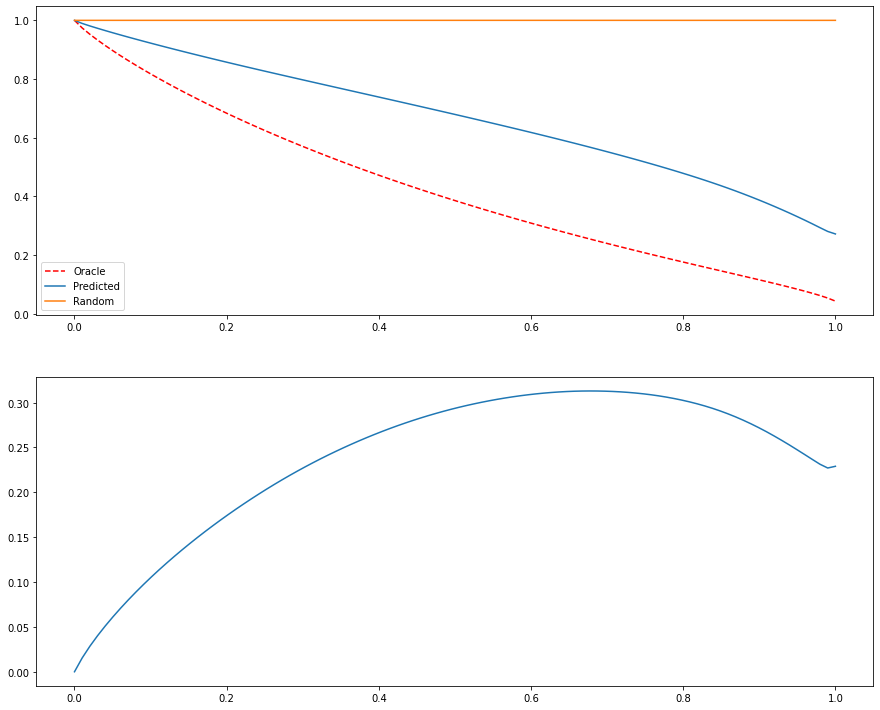

In [12]:
pred_curves, oracle_curves, random_curves = zip(*spars)

pred_curve = np.array(pred_curves).mean(axis=0)
oracle_curve = np.array(oracle_curves).mean(axis=0)
random_curve = np.array(random_curves).mean(axis=0)

error_curve = sparsification.error(oracle_curve, pred_curve)
ause = sparsification.ause(oracle_curve, pred_curve)
aurg = sparsification.aurg(pred_curve, random_curve)

figure, (curve_axis, error_axis) = plt.subplots(2, 1)

x_axis = np.linspace(0, 1, num=len(oracle_curve))

curve_axis.plot(x_axis, oracle_curve, 'r--', label='Oracle')
curve_axis.plot(x_axis, pred_curve, label='Predicted')
curve_axis.plot(x_axis, random_curve, label='Random')
curve_axis.legend()

error_axis.plot(x_axis, error_curve)


figure.set_size_inches((15, 12.5))


print('Hamlyn test set Sparsification:'
      f'\n\t- AUSE: {ause}'
      f'\n\t- AURG: {aurg}')

results_dict['sparsification'] = {
    'ause': float(ause),
    'aurg': float(aurg),
    'curves': {
        'oracle': oracle_curve.tolist(),
        'predicted': pred_curve.tolist(),
        'random': random_curve.tolist(),
        'error': error_curve.tolist()
    }
}

## SCARED MAE

### Setup

In [4]:
scared_model_path = os.path.join('models', 'hamlyn', model_name)
scared_save_to = os.path.join(model_save_to, 'scared')

state_dict = torch.load(scared_model_path, map_location=device)
state_dict = prepare_state_dict(state_dict)

model.load_state_dict(state_dict)

scared_dataset_8 = SCAREDKeyframesLoader(scared_path, 'test', 8, scared_transform)
scared_dataloader_8 = DataLoader(scared_dataset_8, 1)

print(f'Size of SCARED Dataset 8: {len(scared_dataset_8):,} images.')

scared_dataset_9 = SCAREDKeyframesLoader(scared_path, 'test', 9, scared_transform)
scared_dataloader_9 = DataLoader(scared_dataset_9, 1)

print(f'Size of SCARED Dataset 9: {len(scared_dataset_9):,} images.')

Size of SCARED Dataset 8: 5 images.
Size of SCARED Dataset 9: 5 images.


### Run SCARED Evaluation

#### Dataset 8

In [5]:
maes_8, metrics = evaluate_keyframes(model, scared_dataloader_8,
                                     min_depth, max_depth,
                                     save_results_to=scared_save_to,
                                     device=device)
mean_mae_8 = np.mean(maes_8)
std_mae_8 = np.std(maes_8)

print(f'Dataset 8 Keyframe MAEs: {maes_8} mm')
print('Absolute Depth Error on SCARED Dataset 8:'
      f'\n\t- Mean: {mean_mae_8} mm'
      f'\n\t- Std. Deviation: {std_mae_8} mm')

  0%|          | 0/5 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 5/5 [00:18<00:00,  3.64s/batch, mae=45.3]

Dataset 8 Keyframe MAEs: [86.68577800527385, 51.53217062549803, 32.66921690094172, 31.181849049733387, 24.260033110775733] mm
Absolute Depth Error on SCARED Dataset 8:
	- Mean: 45.26580953844454 mm
	- Std. Deviation: 22.59714938446195 mm


#### Dataset 9

In [6]:
maes_9, metrics = evaluate_keyframes(model, scared_dataloader_9,
                                     min_depth, max_depth,
                                     save_results_to=scared_save_to,
                                     device=device)
mean_mae_9 = np.mean(maes_9)
std_mae_9 = np.std(maes_9)

print(f'Dataset 8 Keyframe MAEs: {maes_9} mm')
print('Absolute Depth Error on SCARED Dataset 8:'
      f'\n\t- Mean: {mean_mae_9} mm'
      f'\n\t- Std. Deviation: {std_mae_9} mm')

100%|██████████| 5/5 [00:21<00:00,  4.34s/batch, mae=30]  

Dataset 8 Keyframe MAEs: [53.74654036595182, 28.45652161536874, 34.5020216397841, 18.279314374726056, 15.206820755519947] mm
Absolute Depth Error on SCARED Dataset 8:
	- Mean: 30.03824375027013 mm
	- Std. Deviation: 13.731380225485948 mm


#### Save Results

In [ ]:
results_dict['mae'] = {
    'dataset_8': {
        'mean': float(mean_mae_8),
        'std': float(std_mae_8)
    },
    'dataset_9': {
        'mean': float(mean_mae_9),
        'std': float(std_mae_9)
    }
}

## Save Results

In [ ]:
save_to_path = os.path.join(save_to, model_stem, 'evaluation.json')

with open(save_to_path, 'w+') as f:
    json.dump(results_dict, f, indent=4)